In [332]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [333]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.grid import unstructured_grid
from matplotlib import colors
import os
import numpy as np
import xarray as xr
import subprocess
from IPython.display import Video
import six
import glob
from stompy.plot import nbviz

In [335]:
#run_dir="run_wy2022_take2_common_20220801-v005"
#swim_speeds=[0,1,5,15]
run_dir="run_wy2022_take2_common_20220801-v006"
swim_speeds=[0,5.0,15.0,30,50] # manually transcribed from the notebook with the run.

In [343]:
ds=xr.open_dataset(os.path.join(run_dir,"dwaq_map.nc"))

In [337]:
if 0: # exploring output
    six.moves.reload_module(nbviz)
    viz=nbviz.NBViz([ds])
    viz

Defining Growth Potential
--

Allie's definition:
$$
GP(t)=\frac{S(t)}{S_0} \frac{1}{H} \int_0^H \frac{C(z)}{C_{avg}} \exp(-K_d z) dz
$$

This estimates growth relative to growth if light were at the reference $S_0$ and
there was not any light attenuation.

I want to extend this to include a light half-saturation function, and to keep it in
growth rate units.

$$
G(t) = G_0 \frac{1}{H\ C_{avg}} \int_0^H C(z) \frac{ I_0\exp(-K_d z)}{I_{sat}+I_0\exp(-K_d z)} dz 
$$

$$
G(t) = G_0 \frac{1}{H\ C_{avg}} \int_0^H C(z) \frac{1}{\frac{I_{sat}}{I_0}\exp(K_d z)+1} dz 
$$

Take concentration to be stepwise constant in the layers (could try to be clever and
infer a continuous concentration, but would have to be careful about the surface and potential
for a SML).

$$
G(t) = G_0 \frac{1}{H\ C_{avg}} \sum_i \left[ 
  C_i \int_{z_{i,top}}^{z_{i,bot}} \frac{1}{\frac{I_{sat}}{I_0}\exp(K_d z)+1} dz 
  \right]
$$


$$
G(t) = G_0 \frac{1}{H\ C_{avg}} \sum_i \left[ 
  C_i \left( z - \frac{1}{K_d} \log ( \frac{I_{sat}}{I_0} \exp(K_d z) + 1 ) 
  \right)_{z_{i,top}}^{z_{i,bot}}
  \right]
$$



In [345]:
Isat=1000/25.
def k_indef(z,Kd,I0,Isat):
    # solution of indefinite integral
    # avoid divzero.
    # This creates a lower bound of about 1e-15 on light limitation. Fine.
    I0=np.clip(I0,1e-12,2000)
    if isinstance(z,np.ndarray):
        # stable. Pushing z to 64-bit doesn't hurt either
        z=z.astype(np.float64)
    # This way does a transformation behind the scenes that makes it numerically
    return z - 1/Kd * np.logaddexp( Kd*z+np.log(Isat/I0), np.log(1))
    # This is numerically unstable.
    #return z - 1/Kd * np.log(Isat/I0*np.exp(Kd*z)+1)

def kLight_m(Kd,h_min,h_max,I0,Isat=1000/25.):
    """
    Instantaneous light limitation function, depth-integrated.
    K_d: 1/m light attenuation
    h_min: depth to top of segment (positive-down)
    h_max: depth to bottom of segment (positive-down)
    I0: surface irradiance
    Isat: half-saturation for irradiance
    
    return value has units of meters (consistent with equations above.
    it is meant to be normalized by depth outside the summation.)
    """
    return k_indef(h_max,Kd,I0,Isat) - k_indef(h_min,Kd,I0,Isat)

def kLight(Kd,h_min,h_max,*a,**kw):
    """
    Depth-averaged version of above
    """
    return kLight_m(Kd,h_min,h_max,*a,**kw) / (h_max - h_min)

# With Isat=40, this tops out at 0.96.
#kLight(Kd=1.55,h_min=0,h_max=3.23,I0=1000,Isat=40) # 

<IPython.core.display.Javascript object>


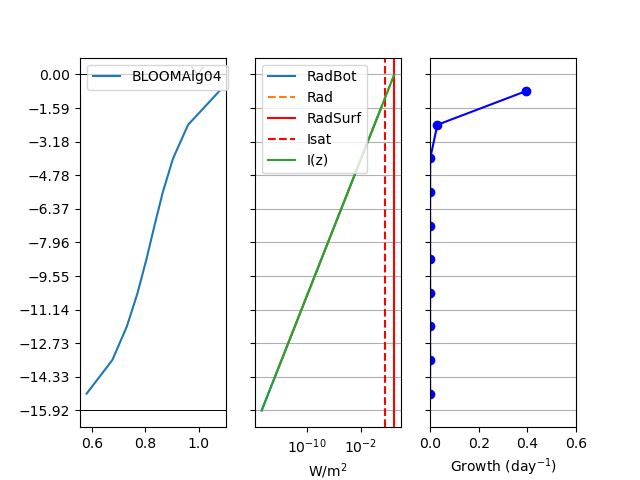

<xarray.DataArray 'BLOOMAlg04' ()>
array(0.05517062)
Coordinates:
    time     datetime64[ns] 2022-08-09T20:30:00


In [347]:
# Choose a spot off SF for developing the growth potential:
#p=[558200, 4.17271e6]
p=[565000, 4.16141e6]
#p=[536400, 4.1630e6]

g=unstructured_grid.UnstructuredGrid.read_ugrid(ds)
c=g.select_cells_nearest(p)

scal='BLOOMAlg04' # 15 m/d
tidx=425

col=ds.isel(time=tidx,face=c)

h_bot=col['LocalDepth'].values
h_top=np.r_[0.0, h_bot[:-1]]
h_int=np.r_[0.0, h_bot]
h_mid=0.5*(h_bot+h_top)
H=float(col['TotalDepth'].mean())


fig,(ax,axI,axG)=plt.subplots(1,3,sharey=True)
# LocalDepth I think is the bottom of the layer.
ax.plot(col[scal],-h_mid,label=scal)
ax.axhline(0.0,color='k',lw=0.7)
ax.axhline(-H,color='k',lw=0.7)
ax.plot(0.8,0.0,marker=7,ms=8,mew=0.7,mfc='none',mec='k',
       transform=ax.get_yaxis_transform())

axI.semilogx(col['RadBot'],-h_bot,label='RadBot')
axI.semilogx(col['Rad'],-h_top,ls='--',label='Rad')

# manually discretized light curve
RadSurf=float(col['RadSurf'].mean())
axI.axvline( RadSurf, color='r', label='RadSurf')
axI.axvline( Isat, color='r',ls='--',label='Isat')

extVl = float(col['ExtVl'].mean())
depth=np.linspace(0,H,100)
axI.semilogx(RadSurf*np.exp(-depth*extVl),-depth,label='I(z)')

axI.set_xlabel("W/m$^2$")
ax.legend(loc='upper left')
axI.legend(loc='upper left')

# Solve the growth exactly, so we don't have to worry about interference
# from depth variation.
#  col[scal]: concentration
C_avg=float(col[scal].mean())

# 
G0_per_day=0.3 # per day, based on upper end of R Kudela measurements. It's possible I should be using a value
# double that -- not sure if the measurements are averaged over 12h on, 12h off, or what.
G0=2*G0_per_day

klight_indef=k_indef(h_int,extVl,RadSurf,40.0)
seg_klight=G0*np.diff(klight_indef) / np.diff(h_int)
axG.plot( seg_klight, -h_mid,'b-o',label='Light limitation')
axG.axis(xmin=0,xmax=G0)
axG.set_xlabel('Growth (day$^{-1}$)')
# Concentration weighted average
growth_avg=G0*np.sum(col[scal]*np.diff(klight_indef)) / (H*C_avg)
print(growth_avg)

axG.set_yticks(-h_int)
axG.grid(axis='y')
axI.grid(axis='y')

In [348]:
def average_growth_one(c,tidx,scal):
    col=ds.isel(time=tidx,face=c)

    h_bot=col['LocalDepth'].values
    h_top=np.r_[0.0, h_bot[:-1]]
    h_int=np.r_[0.0, h_bot]
    h_mid=0.5*(h_bot+h_top)
    H=float(col['TotalDepth'].mean())

    # manually discretized light curve
    RadSurf=float(col['RadSurf'].mean())

    extVl = float(col['ExtVl'].mean())
    
    C_avg=float(col[scal].mean())

    G0_per_day=0.3 # per day, based on upper end of R Kudela measurements. It's possible I should be using a value
    # double that -- not sure if the measurements are averaged over 12h on, 12h off, or what.
    G0=2*G0_per_day

    klight_indef=k_indef(h_int,extVl,RadSurf,40.0)
    seg_klight=np.diff(klight_indef) / np.diff(h_int) # per-layer light limitation function, unitless

    # Concentration weighted average
    growth_avg=G0*np.sum(col[scal]*np.diff(klight_indef)) / (H*C_avg)
    return growth_avg    

p=[565000, 4.16141e6]
g=unstructured_grid.UnstructuredGrid.read_ugrid(ds)
c=g.select_cells_nearest(p)

# Compile a time series for one point:
growths=[average_growth_one(c,tidx,'BLOOMAlg04')
         for tidx in utils.progress(range(ds.dims['time']))]
fig,ax=plt.subplots()
ax.plot(ds.time, growths) ;

INFO:utils:89/1441
INFO:utils:178/1441
INFO:utils:267/1441
INFO:utils:356/1441
INFO:utils:446/1441
INFO:utils:535/1441
INFO:utils:624/1441
INFO:utils:713/1441
INFO:utils:802/1441
INFO:utils:891/1441
INFO:utils:981/1441
INFO:utils:1070/1441
INFO:utils:1159/1441
INFO:utils:1249/1441
INFO:utils:1338/1441
INFO:utils:1427/1441


<IPython.core.display.Javascript object>

In [349]:
def growth_global(tidx,scal):
    snap=ds.isel(time=tidx) # grab data for one time step

    h_bot=snap['LocalDepth'].values # [layer,face]
    # depth to layer interfaces, positive down.
    h_int=np.concatenate([np.zeros_like(h_bot[:1,:]),h_bot],axis=0) # [interface,face]

    # depth-uniform values, so just pick off top layer
    H=snap['TotalDepth'].isel(layer=0) # [face]
    RadSurf=snap['RadSurf'].isel(layer=0).values # [face]
    extVl = snap['ExtVl'].isel(layer=0).values
    
    # can leave this with dimensions -- 
    C_avg=snap[scal].mean(dim='layer')

    G0_per_day=0.3 # per day, based on upper end of R Kudela measurements. 
    # Not 100% sure if the measurements are averaged over 12h on, 12h off, or what.
    # The max insolation used is close to a reasonable max daily average, so I'm assuming that
    # the growth is also a daily average. Try to get in the right ball park by doubling.
    G0=2*G0_per_day

    # add None to help broadcast against h_int
    klight_indef=k_indef(h_int,extVl[None,:],RadSurf[None,:],40.0)
    
    # Concentration weighted average
    klight_def=np.diff(klight_indef,axis=0) # solution to the per-layer definite integral
    if np.any(~np.isfinite(klight_def)):
        import pdb
        pdb.set_trace()
    growth_int=G0*np.sum(snap[scal].values*klight_def,axis=0) / C_avg
    growth_int[ np.isnan(growth_int)] = 0.0 # hopefully not some other issue...
    growth_avg=growth_int/H.clip(1e-4)

    return dict(growth_avg=growth_avg,growth_int=growth_int)


In [ ]:
# Frames for instantaneous rates
scal='BLOOMAlg04'
ws=15.0

fig=plt.figure()
fig_dir=f"frames-growth-{scal}"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
for tidx in utils.progress(range(ds.dims['time'])):
    fig.clf()
    ax=fig.add_axes([0,0,1,1])
    growth_snap=growth_global(tidx,scal)['growth_avg']
    ax.axis('off')

    coll=g.plot_cells(values=growth_snap,cmap='turbo',clim=[0,0.65],lw=0.5,edgecolor='face')
    cax=fig.add_axes([0.75, 0.5,0.03,0.35])
    plt.colorbar(coll,cax=cax,label='day$^{-1}$')
    t_str=(ds.time.isel(time=tidx)-np.timedelta64(8,'h')).dt.strftime('%Y-%m-%d %H:%M PST').item()
    ax.text(0.6,0.97,f'w$_s$={ws} m/day\nt={t_str}',transform=ax.transAxes,va='top')
    ax.axis((517098.6559379606, 594990.8662815248, 4139373.112448552, 4200085.496536991))
    fig.savefig(os.path.join(fig_dir,f"frame_{tidx:04d}.png"),dpi=100)
    plt.draw()
    plt.pause(0.01)

<IPython.core.display.Javascript object>

INFO:utils:4/1441
INFO:utils:7/1441
INFO:utils:12/1441
INFO:utils:16/1441


In [182]:
from stompy.plot import mkanim
mkanim.mkanim("BLOOMAlg04-instant.mp4",frame_path="frames-growth-BLOOMAlg04/frame_%04d.png")

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [183]:
Video("BLOOMAlg04-instant.mp4")

In [270]:
# save them all to a dataset so we can do some averaging afterwards.

ds_growth=xr.Dataset()
ds_growth['time']=ds.time
ds_growth.attrs['waq_run_dir']=run_dir
tracers=[scal for scal in list(ds) if scal.startswith('BLOOMAlg')]
ds_growth['tracers']=('tracer',),tracers
ds_growth['swim_speed']=('tracer',),swim_speeds # set at the top along with run_dir
ds_growth['swim_speed'].attrs['units']='m d-1'

for scal in tracers:
    growth_avg=np.zeros( (ds.dims['time'],ds.dims['face']), np.float32)
    growth_int=np.zeros( (ds.dims['time'],ds.dims['face']), np.float32)
    for tidx in utils.progress(range(ds.dims['time'])):
        growth_snap=growth_global(tidx,scal)
        growth_avg[tidx,:]=growth_snap['growth_avg']
        growth_int[tidx,:]=growth_snap['growth_int']
        
    ds_growth[scal+"_avg"]=('time','face'),growth_avg
    ds_growth[scal+"_int"]=('time','face'),growth_int

growth_nc_fn=os.path.join(run_dir,'growth-rates.nc')
ds_growth.to_netcdf(growth_nc_fn)

INFO:utils:180/1441
INFO:utils:357/1441
INFO:utils:529/1441
INFO:utils:703/1441
INFO:utils:877/1441
INFO:utils:1052/1441
INFO:utils:1227/1441
INFO:utils:1401/1441
INFO:utils:175/1441
INFO:utils:351/1441
INFO:utils:526/1441
INFO:utils:700/1441
INFO:utils:873/1441
INFO:utils:1048/1441
INFO:utils:1223/1441
INFO:utils:1398/1441
INFO:utils:175/1441
INFO:utils:349/1441
INFO:utils:525/1441
INFO:utils:701/1441
INFO:utils:876/1441
INFO:utils:1051/1441
INFO:utils:1225/1441
INFO:utils:1398/1441
INFO:utils:174/1441
INFO:utils:347/1441
INFO:utils:521/1441
INFO:utils:695/1441
INFO:utils:868/1441
INFO:utils:1043/1441
INFO:utils:1217/1441
INFO:utils:1391/1441
INFO:utils:174/1441
INFO:utils:347/1441
INFO:utils:522/1441
INFO:utils:695/1441
INFO:utils:869/1441
INFO:utils:1045/1441
INFO:utils:1220/1441
INFO:utils:1395/1441


<IPython.core.display.Javascript object>


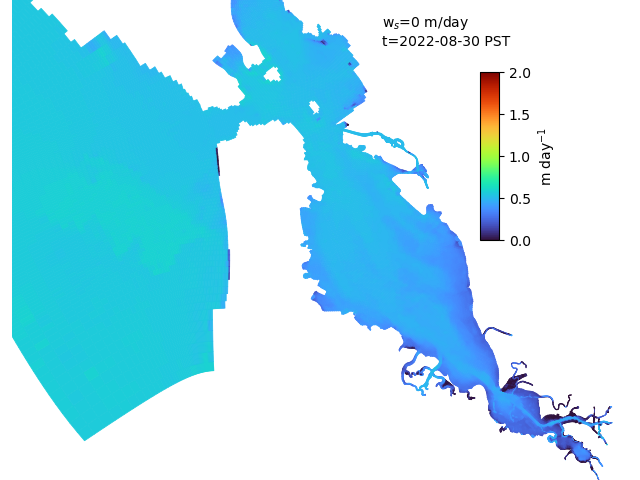

INFO:utils:5
INFO:utils:9
INFO:utils:15
INFO:utils:20
INFO:utils:25


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

<IPython.core.display.Javascript object>


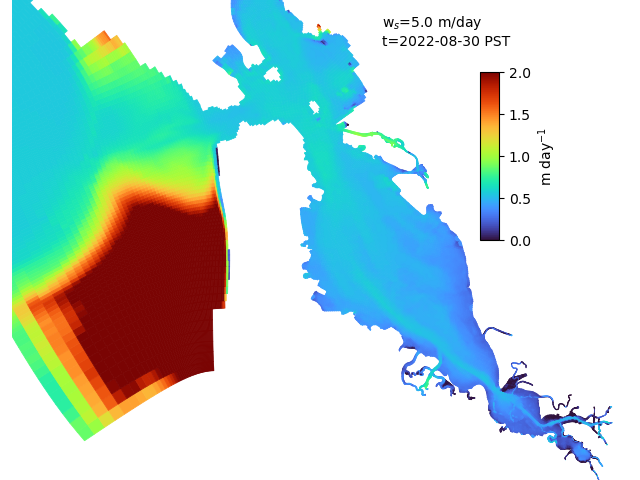

INFO:utils:5
INFO:utils:10
INFO:utils:15
INFO:utils:20
INFO:utils:25


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

<IPython.core.display.Javascript object>


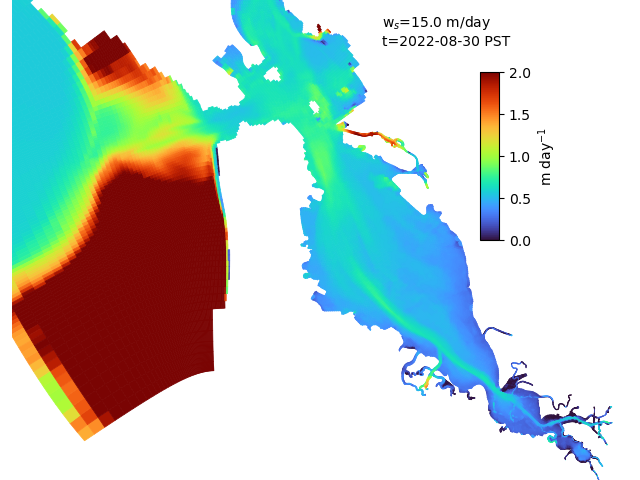

INFO:utils:5
INFO:utils:10
INFO:utils:16
INFO:utils:22
INFO:utils:27


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

<IPython.core.display.Javascript object>


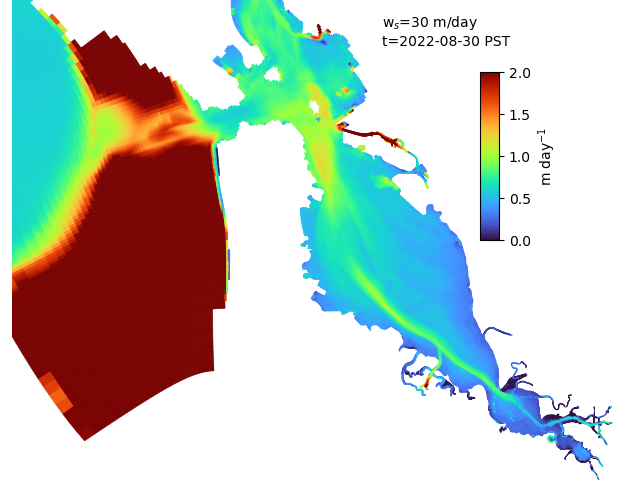

INFO:utils:5
INFO:utils:10
INFO:utils:16
INFO:utils:21
INFO:utils:26


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

<IPython.core.display.Javascript object>


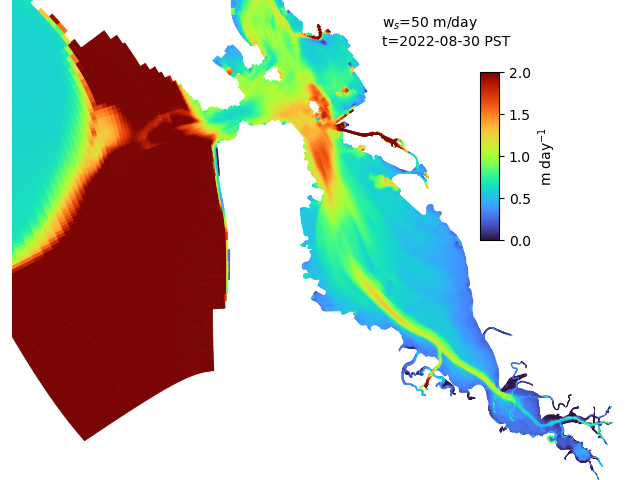

INFO:utils:5
INFO:utils:11
INFO:utils:16
INFO:utils:22
INFO:utils:28


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [274]:
# Plot daily averages.
ds_growth=xr.open_dataset(growth_nc_fn)
ds_growth['time_pst']=ds_growth['time']-np.timedelta64(8,'h')

for scal,ws in zip(tracers,swim_speeds):
    for mode in ['int']: # TMP ['avg','int']:
        if mode=='avg':
            clim=[0,0.3]
        elif mode=='int':
            clim=[0,2.0]
        fig=plt.figure()

        fig_dir=f"frames-growth-daily-{mode}-{scal}"

        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

        daily_average=ds_growth[scal+'_'+mode].groupby(ds_growth.time_pst.dt.date).mean()

        for tidx,date in utils.progress(enumerate(daily_average.date)):
            fig.clf()
            ax=fig.add_axes([0,0,1,1])
            growth_snap=daily_average.isel(date=tidx)
            ax.axis('off')

            coll=g.plot_cells(values=growth_snap,cmap='turbo',clim=clim,
                             edgecolor='face',lw=0.5)
            cax=fig.add_axes([0.75, 0.5,0.03,0.35])
            if mode=='avg':
                units='day$^{-1}$'
            elif mode=='int':
                units='m day$^{-1}$'
            plt.colorbar(coll,cax=cax,label=units)
            t_str=date.item().strftime('%Y-%m-%d PST')
                    
            ax.text(0.6,0.97,f'w$_s$={ws} m/day\nt={t_str}',transform=ax.transAxes,va='top')
            ax.axis((517098.6559379606, 594990.8662815248, 4139373.112448552, 4200085.496536991))
            fig.savefig(os.path.join(fig_dir,f"frame_{tidx:04d}.png"),dpi=100)
        
        mkanim.mkanim(f"{scal}-{ws}mpd-daily-{mode}.mp4",fig_dir+"/frame_%04d.png",
              fps=1)

<IPython.core.display.Javascript object>


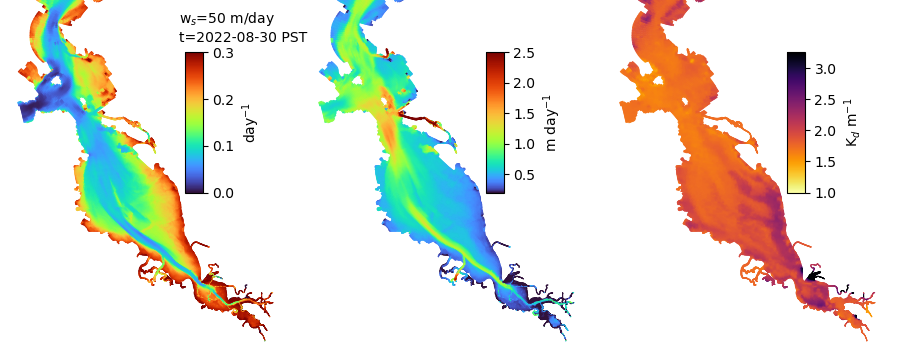

INFO:utils:3
INFO:utils:5
INFO:utils:8
INFO:utils:10
INFO:utils:12
INFO:utils:15
INFO:utils:17
INFO:utils:20
INFO:utils:23
INFO:utils:25
INFO:utils:28


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

INFO:utils:3
INFO:utils:5
INFO:utils:8
INFO:utils:11
INFO:utils:13
INFO:utils:16
INFO:utils:19
INFO:utils:21
INFO:utils:23
INFO:utils:26
INFO:utils:28


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

INFO:utils:3
INFO:utils:5
INFO:utils:8
INFO:utils:11
INFO:utils:13
INFO:utils:16
INFO:utils:19
INFO:utils:22
INFO:utils:24
INFO:utils:27
INFO:utils:30


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

INFO:utils:3
INFO:utils:5
INFO:utils:8
INFO:utils:11
INFO:utils:14
INFO:utils:16
INFO:utils:19
INFO:utils:22
INFO:utils:24
INFO:utils:27
INFO:utils:30


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

INFO:utils:3
INFO:utils:5
INFO:utils:7
INFO:utils:10
INFO:utils:12
INFO:utils:15
INFO:utils:18
INFO:utils:20
INFO:utils:23
INFO:utils:26
INFO:utils:28
INFO:utils:30


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [331]:
# triptych with depth averaged, depth-integrated, and the Kd field
from matplotlib import cm
import stompy.plot.cmap as scmap

daily_Kd=ds['ExtVl'].isel(layer=0).groupby((ds.time-np.timedelta64(8,'h')).dt.date).mean()
daily_Rad=ds['RadSurf'].isel(layer=0).groupby((ds.time-np.timedelta64(8,'h')).dt.date).mean()


ds_growth=xr.open_dataset(growth_nc_fn)
ds_growth['time_pst']=ds_growth['time']-np.timedelta64(8,'h')

fig=plt.figure(figsize=(9,3.5))

zoom=(538872.022219604, 597942.8780323294, 4137242.5345184947, 4206617.972956329)
clip_point=np.r_[ 543100, 4.1843e6]
clip_normal=np.r_[1.0,0.3]
cc=g.cells_center()
sel=(cc-clip_point).dot(clip_normal)>0

for scal,ws in zip(tracers,swim_speeds):
    # if ws!=15: continue # TMP
        
    fig_dir=f"frames-triptych-daily-{scal}"

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    daily_avg_average=ds_growth[scal+'_avg'].groupby(ds_growth.time_pst.dt.date).mean()
    daily_int_average=ds_growth[scal+'_int'].groupby(ds_growth.time_pst.dt.date).mean()

    for tidx,date in utils.progress(enumerate(daily_average.date)):
        #if tidx!=8: continue # TMP
        fig.clf()
        ax_avg=fig.add_subplot(1,3,1)
        ax_int=fig.add_subplot(1,3,2)
        ax_Kd =fig.add_subplot(1,3,3)
        for ax in [ax_avg,ax_int,ax_Kd]:
            ax.set_adjustable('datalim')
            ax.axis('off')
        fig.subplots_adjust(left=0.0,right=1.,top=1.0,bottom=0.0,wspace=0.01)
        
        for ax,data,mode in [(ax_avg,daily_avg_average,'avg'),
                             (ax_int,daily_int_average,'int'),
                             (ax_Kd, daily_Kd, 'Kd')]:
            if mode=='avg':
                clim=[0,0.3]
                units='day$^{-1}$'
                cmap='turbo'
            elif mode=='int':
                clim=[0.2,2.5]
                units='m day$^{-1}$'
                cmap='turbo'
                cmap=scmap.cmap_transform(cm.turbo,lambda s: s**0.7)
            elif mode=='Kd':
                clim=[1.0,3.25]
                units="K$_d$ m$^{-1}$"
                cmap='inferno_r'
            coll=g.plot_cells(values=data.isel(date=tidx),cmap=cmap,clim=clim,
                             edgecolor='face',lw=0.5,ax=ax,mask=sel)
            pos=ax.get_position()
            cax=fig.add_axes([pos.xmin+0.62*pos.width,
                              pos.ymin+0.45*pos.height,
                              0.02,pos.height*0.4])
            plt.colorbar(coll,cax=cax,label=units)
            t_str=date.item().strftime('%Y-%m-%d PST')

            ax.axis(zoom)
        ax_avg.text(0.6,0.97,f'w$_s$={ws} m/day\nt={t_str}',transform=ax_avg.transAxes,va='top')
        fig.savefig(os.path.join(fig_dir,f"frame_{tidx:04d}.png"),dpi=100)
    video_fn=f"{scal}-{ws}mpd-daily-triptych.mp4"
    mkanim.mkanim(video_fn,fig_dir+"/frame_%04d.png", fps=1)
    

In [313]:
video_fn

'BLOOMAlg01-0mpd-daily-triptych.mp4'

In [314]:
Video(video_fn)

In [217]:
ls frames-growth-daily-BLOOMAlg04/

frame_0000.png  frame_0007.png  frame_0014.png  frame_0021.png  frame_0028.png
frame_0001.png  frame_0008.png  frame_0015.png  frame_0022.png  frame_0029.png
frame_0002.png  frame_0009.png  frame_0016.png  frame_0023.png  frame_0030.png
frame_0003.png  frame_0010.png  frame_0017.png  frame_0024.png
frame_0004.png  frame_0011.png  frame_0018.png  frame_0025.png
frame_0005.png  frame_0012.png  frame_0019.png  frame_0026.png
frame_0006.png  frame_0013.png  frame_0020.png  frame_0027.png
